# CS6120 NLP Fall 2023 Assignment 4

## About the transformer

### 1. Background: 
- Study the transformer code provided
- Apply Transformer code provided in the module to train a language models that generates financial. discourse in Warren Buffet's style. Train you model using Warren Buffets's Annual Letters to shareholders.

1.1. Bigram Language Model

In [15]:
# check GPU is work
# Train the model using a suitable optimizer and loss function.
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


In [61]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

''' Look at all previous tokens to generate next
    @Author: Uzair Ahmad
    2022
    +TransformerBlock 
'''


class TransformerBlockLM(nn.Module):
    class TransformerBlock(nn.Module):
        def __init__(self, head_count, in_size, out_size):
            super().__init__()
            self.comm = TransformerBlockLM.MultiHeadAttention(head_count=head_count,
                                                              in_size=in_size,
                                                              out_size=out_size)
            self.think = TransformerBlockLM.MLP(embed_size=out_size)

        def forward(self, x):
            return x + self.think(x + self.comm(x))

    class MLP(nn.Module):
        # FFNN (embed_size, embed_size*4, embed_size)
        def __init__(self, embed_size):
            super().__init__()
            self.mlp = nn.Sequential(nn.Linear(embed_size, embed_size * 4),
                                     nn.ReLU(),
                                     nn.Linear(embed_size * 4, embed_size))
            self.layerNorm = nn.LayerNorm(embed_size)

        def forward(self, x):  # think
            return self.layerNorm(self.mlp(x))  # paper - after
            # return self.mlp(self.layerNorm(x)) # alternate - before

    class MultiHeadAttention(nn.Module):
        """
        multiple parallel SA heads (communication among words)
        """

        def __init__(self, head_count, in_size, out_size):
            super().__init__()
            self.heads = nn.ModuleList(
                TransformerBlockLM.SelfAttentionHead(in_size, out_size // head_count)
                for _ in range(head_count)
            )
            self.layerNorm = nn.LayerNorm(out_size)
            # self.proj = nn.Linear(out_size, out_size)

        def forward(self, x):
            # concat over channel/embeddings_size dimension
            return self.layerNorm(torch.cat([head(x) for head in self.heads], dim=-1))  # paper - after
            # return torch.cat([head(self.layerNorm(x)) for head in self.heads], dim=-1) # alternate - before
            # return self.proj(torch.cat([head(x) for head in self.heads], dim=-1))

    class SelfAttentionHead(nn.Module):
        def __init__(self, in_size, out_size):
            """
            in_size is embed_size
            out_size is head_size
            """
            super().__init__()
            self.head_size = out_size
            self.K = nn.Linear(in_size, self.head_size, bias=False)
            self.Q = nn.Linear(in_size, self.head_size, bias=False)
            self.V = nn.Linear(in_size, self.head_size, bias=False)

        def forward(self, x):
            keys = self.K(x)
            queries = self.Q(x)
            # affinities :
            # all the queries will dot-product with all the keys
            # transpose (swap) second dimension (input_length) with third (head_size)
            keys_t = keys.transpose(1, 2)
            autocorrs = (queries @ keys_t) * (self.head_size ** -0.5)  # (batch_size x input_length x input_length)
            '''
            (batch_size x input_length x embed_size) @ (batch_size x embed_size x input_length) ----> (batch_size x input_length x input_length)
            '''
            autocorrs = torch.tril(autocorrs)
            autocorrs = autocorrs.masked_fill(autocorrs == 0, float('-inf'))
            autocorrs = torch.softmax(autocorrs, dim=-1)
            values = self.V(x)  # (batch_size x input_length x head_size)
            out = autocorrs @ values
            return out

    def __init__(self, batch_size=4,
                 input_length=8,
                 embed_size=16,
                 sa_head_size=8,
                 sa_multihead_count=4,
                 pos_embed=False,
                 include_mlp=False):
        super().__init__()
        self.blocks = None
        self.ffn = None
        self.sa_heads = None
        # sa_head_size head_size of self-attention module
        self.sa_head_size = sa_head_size
        self.sa_multihead_count = sa_multihead_count

        self.val_data = None
        self.train_data = None
        self.val_text = None
        self.train_text = None
        self.K = None
        self.linear_sahead_to_vocab = None
        self.vocab = None
        self.token_embeddings_table = None
        self.vocab_size = None
        self.encoder = None
        self.decoder = None
        self.vocab_size: int
        self.is_pos_emb = pos_embed
        self.include_mlp = include_mlp
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # input_length = how many consecutive tokens/chars in one input
        self.input_length = input_length
        # batch_size = how many inputs are going to be processed in-parallel (on GPU)
        self.batch_size = batch_size
        # embed_size = embedding size
        self.embed_size = embed_size

        self.lm_head = None
        self.position_embeddings_table = None

    def forward(self, in_ids, target=None):
        in_ids_emb = self.token_embeddings_table(in_ids[:, -self.input_length:])
        if self.is_pos_emb:
            in_ids_pos_emb = self.position_embeddings_table(
                torch.arange(in_ids[:, -self.input_length:].shape[1], device=self.device)
            )
            in_ids_emb = in_ids_emb + in_ids_pos_emb

        block_outputs = self.blocks(in_ids_emb)
        logits = self.linear_sahead_to_vocab(block_outputs)  # compute

        if target is None:
            ce_loss = None
        else:
            batch_size, input_length, vocab_size = logits.shape
            logits_ = logits.view(batch_size * input_length, vocab_size)
            targets = target.view(batch_size * input_length)
            ce_loss = F.cross_entropy(logits_, targets)
        return logits, ce_loss

    def fit(self, train_iters=100, eval_iters=10, lr=0.0001):
        """
        train_iters = how many training iterations
        eval_iters = how many batches to evaluate to get average performance
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for iteration in range(train_iters):
            if iteration % eval_iters == 0:
                avg_loss = self.eval_loss(eval_iters)
                print(f"iter {iteration}: train {avg_loss['train']} val {avg_loss['eval']}")
            inputs, targets = self.get_batch(split='train')
            _, ce_loss = self(inputs, targets)
            optimizer.zero_grad(set_to_none=True)  # clear gradients of previous step
            ce_loss.backward()  # propagate loss back to each unit in the network
            optimizer.step()  # update network parameters w.r.t the loss
        # torch.save(self, 'sa_pos_')

    def generate(self, context_token_ids, max_new_tokens):
        for _ in range(max_new_tokens):
            token_rep, _ = self(context_token_ids)
            last_token_rep = token_rep[:, -1, :]
            probs = F.softmax(last_token_rep, dim=1)
            next_token = torch.multinomial(probs, num_samples=1)
            context_token_ids = torch.cat((context_token_ids, next_token), dim=1)
        output_text = self.decoder(context_token_ids[0].tolist())
        return output_text

    @torch.no_grad()  # tell torch not to prepare for back-propagation (context manager)
    def eval_loss(self, eval_iters):
        perf = {}
        # set dropout and batch normalization layers to evaluation mode before running inference.
        self.eval()
        for split in ['train', 'eval']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                tokens, targets = self.get_batch(split)  # get random batch of inputs and targete
                _, ce_loss = self(tokens, targets)  # forward pass
                losses[k] = ce_loss.item()  # the value of loss tensor as a standard Python number
            perf[split] = losses.mean()
        self.train()  # turn-on training mode-
        return perf

    def prep(self, corpus):
        self.vocab = sorted(list(set(corpus)))
        self.vocab_size = len(self.vocab)
        c2i = {c: i for i, c in
               enumerate(self.vocab)}  # char c to integer i map. assign value i for every word in vocab
        i2c = {i: c for c, i in c2i.items()}  # integer i to char c map

        self.encoder = lambda doc: [c2i[c] for c in doc]
        self.decoder = lambda nums: ''.join([i2c[i] for i in nums])

        n = len(text)
        self.train_text = text[:int(n * 0.9)]
        self.val_text = text[int(n * 0.9):]

        self.train_data = torch.tensor(self.encoder(self.train_text), 
                                       dtype=torch.long, 
                                       device=self.device)
        self.val_data = torch.tensor(self.encoder(self.val_text), 
                                     dtype=torch.long,
                                     device=self.device)

        # look-up table for embeddings (vocab_size x embed_size)
        # it will be mapping each token id to a vector of embed_size
        # a wrapper to store vector representations of each token
        self.token_embeddings_table = \
            nn.Embedding(self.vocab_size, self.embed_size).to(self.device)

        if self.is_pos_emb:
            self.position_embeddings_table = nn.Embedding(self.input_length, self.embed_size).to(self.device)

        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
        )
        # linear projection of sa_head output to vocabulary
        self.linear_sahead_to_vocab = nn.Linear(self.sa_head_size, self.vocab_size)

    def get_batch(self, split='train'):
        data = self.train_data if split == 'train' else self.val_data
        # get random chunks of length batch_size from data
        ix = torch.randint(len(data) - self.input_length,
                           (self.batch_size,))
        inputs_batch = torch.stack([data[i:i + self.input_length] for i in ix])
        targets_batch = torch.stack([data[i + 1:i + self.input_length + 1] for i in ix])
        inputs_batch = inputs_batch.to(self.device)
        targets_batch = targets_batch.to(self.device)
        # inputs_batch is
        return inputs_batch, targets_batch

In [63]:
with open('./emily_dickonson.txt', 'r') as f:
    text = f.read()

# text = 'a quick brown fox jumps over the lazy dog.\n ' \
#        'lazy dog and a quick brown fox.\n' \
#        'the dog is lazy and the fox jumps quickly.\n' \
#        'a fox jumps over the dog because he is lazy.\n' \
#        'dog is lazy and fox is brown. she quickly jumps over the lazy dog.'

model = TransformerBlockLM(batch_size=64,
                           input_length=32,
                           embed_size=128,
                           sa_multihead_count=8,
                           sa_head_size=128,
                           pos_embed=True,
                           include_mlp=True)
model.prep(text)
model = model.to(model.device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'params {sum([np.prod(p.size()) for p in model_parameters])}')
input_batch, output_batch = model.get_batch(split='train')
_, _ = model(input_batch, output_batch)
model.fit(train_iters=4000, eval_iters=1000, lr=1e-3)
outputs = model.generate(context_token_ids=torch.zeros((1, 1),
                                                        dtype=torch.long,
                                                        device=model.device),
                         max_new_tokens=1000)
print(outputs)


params 1112398
iter 0: train 5.391458034515381 val 5.360659122467041
iter 1000: train 1.647735357284546 val 1.708343744277954
iter 2000: train 1.369718313217163 val 1.7124419212341309
iter 3000: train 1.1540275812149048 val 1.8630141019821167

As if I butch the fall is the grave
   His superfluous all futures travelled both,
It assasin familiar guest;
Hint, your little, I would countenance
As golden break for me
All other passed her bacinant
   Him goneaden bure.

XI.

I much joy can from somer
That skirror
   I have cunetess music, sometimes of gold
On bleading to break,
Reces if I fermanted daffodil
For himself it hinder to fit;
There imperial its propice
(t any passed
   Behind a single clause,
 Fuspirite fores on my stem,
" and name my more you!
I mind my time, apart hope, for see
   To have the summer eymed homesty fingers with its passed
   They will of finished sinks,
Till quaint that way.
To Im s there, —
Him stares in given lip,
   Poroporog absort trem
And siervel as yet done

### 1.1. Identify the points where code is different from the proposed architecture in Google's patent (provided in the module) (5 points)

The main different from the google's patent with our `LM_TransformerBlock_MLP_PosEmb_AddNormOpt.py` is that:
-  Encoder-decoder architecture: Google's patent describes a system with clearly separated encoders and decoders. While our TransformerBlockLM code implements a Transformer module, the Python code implements a Transformer module, which can be part of the encoder or decoder, but does not clearly distinguish between the two components.

- Self-attention and feed-forward layers: The patent may describe a more general architecture, but the code we used implements a specific self-attention and feed-forward layer structure, and may include the layer normalization step, which There may not be a clear description in the patent.

- Autoregressive generation: The decoder in Google’s patent appears to use an autoregressive approach to generate the output sequence. We have a similar implementation in our code that implements an autoregressive generating function, but it's not clear how this aligns with the specific mechanism described in the patent.

- Output generation: The decoder mentioned in the patent may use linear layers and softmax layers to generate output probability distributions. Although our code may take a similar approach, the specific configuration and parameters may be different.

- Training and evaluation: Our code contains specific training and evaluation methods that may not be detailed in Google patents. Our python implementation may include specific details such as loss function calculation, gradient descent, and performance evaluation.

### 1.2. Re-design the code to make it more intuitive. Give arguments why do you think your code is better. (5 points)

#### I. Fix bugs

- change tehsor on two device to on one device, like gpu not cpu. I switch the line 17 and 18. 
- model.prep(text)
- model = model.to(model.device)

Then we can fix them use gpu. 

#### II. Add plot to show the loss function

- I add a function draw the plot to show the loss function

#### III. Re-design for `fit(self, train_iters=100, eval_iters=10, lr=0.0001)`
- I add avarable paramter about `train_losses` , `val__losses` and `iterations`. Then I can draw the plot base on these paramter. 

#### IV. Edit the implement part, change bigger max number like 10000 not 1000.
- max_new_tokens=10000

#### V. Add save result to txt file 
- to save the whole document to txt, which easy to check the sentence. 

#### VI. Add Perplexity to text the Metrics for Language Model Performance
- use formular $Perplexity = e^{(Cross \ Entropy \ Loss)}$

### 2. Apply Transformer code provided in the module to train a language models that generates financial discourse in Warren Buffet's style. Train you model using Warren Buffets's Annual Letters to shareholders

In [65]:
# Loading and preparing the Warren Buffet dataset
with open('WarrenBuffet.txt', 'r') as file:
    data = file.read()
    
print(data[:1000])
print(type(data))
print('The length of the {} is {}' .format('`data`', len(data)))

BERKSHIRE HATHAWAY INC. 



To the Shareholders of Berkshire Hathaway Inc.: 

Our gain in net worth during 2006 was $16.9 billion, which increased the per-share book value of 
both our Class A and Class B stock by 18.4%. Over the last 42 years (that is, since present management 
took over) book value has grown from $19 to $70,281, a rate of 21.4% compounded annually.* 

We believe that $16.9 billion is a record for a one-year gain in net worth - more than has ever 
been booked by any American business, leaving aside boosts that have occurred because of mergers (e.g., 
AOL's purchase of Time Warner). Of course, Exxon Mobil and other companies earn far more than 
Berkshire, but their earnings largely go to dividends and/or repurchases, rather than to building net worth. 

All that said, a confession about our 2006 gain is in order. Our most important business, 
insurance, benefited from a large dose of luck: Mother Nature, bless her heart, went on vacation. After 
hammering us with hurri

In [70]:
# import package
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

- Pre-processing:
- Tokenize the dataset.
- Remove stopwords and non-alphabetic tokens.

In [68]:
# Clean data
def clean_corpus(line: list[str]) -> list[str]:
    '''
    preprocess and clean a given line.

    - line: The text line to be cleaned.
    ---
    - list: A list of preprocessed tokens from the line.
    '''
    tokens = word_tokenize(line.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  
    return tokens


In [69]:
# Preprocessing the data
lines: list[list[str]] = []

# Predefined list of stop words
stop_words: set = set(stopwords.words('english'))

# Tokenize the text documents and update the lists word_list and lines
lines = clean_corpus(data)
print(len(lines))
lines[:10]

26557


['berkshire',
 'hathaway',
 'shareholders',
 'berkshire',
 'hathaway',
 'gain',
 'net',
 'worth',
 'billion',
 'increased']

Implement Re-build TransformerBlockLM

In [71]:
class TransformerBlockLM(nn.Module):
    class TransformerBlock(nn.Module):
        def __init__(self, head_count, in_size, out_size):
            super().__init__()
            self.comm = TransformerBlockLM.MultiHeadAttention(head_count=head_count,
                                                              in_size=in_size,
                                                              out_size=out_size)
            self.think = TransformerBlockLM.MLP(embed_size=out_size)

        def forward(self, x):
            return x + self.think(x + self.comm(x))

    class MLP(nn.Module):
        # FFNN (embed_size, embed_size*4, embed_size)
        def __init__(self, embed_size):
            super().__init__()
            self.mlp = nn.Sequential(nn.Linear(embed_size, embed_size * 4),
                                     nn.ReLU(),
                                     nn.Linear(embed_size * 4, embed_size))
            self.layerNorm = nn.LayerNorm(embed_size)

        def forward(self, x):  # think
            return self.layerNorm(self.mlp(x))  # paper - after
            # return self.mlp(self.layerNorm(x)) # alternate - before

    class MultiHeadAttention(nn.Module):
        """
        multiple parallel SA heads (communication among words)
        """

        def __init__(self, head_count, in_size, out_size):
            super().__init__()
            self.heads = nn.ModuleList(
                TransformerBlockLM.SelfAttentionHead(in_size, out_size // head_count)
                for _ in range(head_count)
            )
            self.layerNorm = nn.LayerNorm(out_size)
            # self.proj = nn.Linear(out_size, out_size)

        def forward(self, x):
            # concat over channel/embeddings_size dimension
            return self.layerNorm(torch.cat([head(x) for head in self.heads], dim=-1))  # paper - after
            # return torch.cat([head(self.layerNorm(x)) for head in self.heads], dim=-1) # alternate - before
            # return self.proj(torch.cat([head(x) for head in self.heads], dim=-1))

    class SelfAttentionHead(nn.Module):
        def __init__(self, in_size, out_size):
            """
            in_size is embed_size
            out_size is head_size
            """
            super().__init__()
            self.head_size = out_size
            self.K = nn.Linear(in_size, self.head_size, bias=False)
            self.Q = nn.Linear(in_size, self.head_size, bias=False)
            self.V = nn.Linear(in_size, self.head_size, bias=False)

        def forward(self, x):
            keys = self.K(x)
            queries = self.Q(x)
            # affinities :
            # all the queries will dot-product with all the keys
            # transpose (swap) second dimension (input_length) with third (head_size)
            keys_t = keys.transpose(1, 2)
            autocorrs = (queries @ keys_t) * (self.head_size ** -0.5)  # (batch_size x input_length x input_length)
            '''
            (batch_size x input_length x embed_size) @ (batch_size x embed_size x input_length) ----> (batch_size x input_length x input_length)
            '''
            autocorrs = torch.tril(autocorrs)
            autocorrs = autocorrs.masked_fill(autocorrs == 0, float('-inf'))
            autocorrs = torch.softmax(autocorrs, dim=-1)
            values = self.V(x)  # (batch_size x input_length x head_size)
            out = autocorrs @ values
            return out

    def __init__(self, batch_size=4,
                 input_length=8,
                 embed_size=16,
                 sa_head_size=8,
                 sa_multihead_count=4,
                 pos_embed=False,
                 include_mlp=False):
        super().__init__()
        self.blocks = None
        self.ffn = None
        self.sa_heads = None
        # sa_head_size head_size of self-attention module
        self.sa_head_size = sa_head_size
        self.sa_multihead_count = sa_multihead_count

        self.val_data = None
        self.train_data = None
        self.val_text = None
        self.train_text = None
        self.K = None
        self.linear_sahead_to_vocab = None
        self.vocab = None
        self.token_embeddings_table = None
        self.vocab_size = None
        self.encoder = None
        self.decoder = None
        self.vocab_size: int
        self.is_pos_emb = pos_embed
        self.include_mlp = include_mlp
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # input_length = how many consecutive tokens/chars in one input
        self.input_length = input_length
        # batch_size = how many inputs are going to be processed in-parallel (on GPU)
        self.batch_size = batch_size
        # embed_size = embedding size
        self.embed_size = embed_size

        self.lm_head = None
        self.position_embeddings_table = None

    def forward(self, in_ids, target=None):
        in_ids_emb = self.token_embeddings_table(in_ids[:, -self.input_length:])
        if self.is_pos_emb:
            in_ids_pos_emb = self.position_embeddings_table(
                torch.arange(in_ids[:, -self.input_length:].shape[1], device=self.device)
            )
            in_ids_emb = in_ids_emb + in_ids_pos_emb

        block_outputs = self.blocks(in_ids_emb)
        logits = self.linear_sahead_to_vocab(block_outputs)  # compute

        if target is None:
            ce_loss = None
        else:
            batch_size, input_length, vocab_size = logits.shape
            logits_ = logits.view(batch_size * input_length, vocab_size)
            targets = target.view(batch_size * input_length)
            ce_loss = F.cross_entropy(logits_, targets)
        return logits, ce_loss

    def fit(self, train_iters=100, eval_iters=10, lr=0.0001):
        """
        train_iters = how many training iterations
        eval_iters = how many batches to evaluate to get average performance
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        train_losses = []
        val_losses = []
        iterations = []
        
        for iteration in range(train_iters):
            if iteration % eval_iters == 0:
                avg_loss = self.eval_loss(eval_iters)
                print(f"iter {iteration}: train {avg_loss['train']} val {avg_loss['eval']}")
                iterations.append(iteration)
                train_losses.append(avg_loss['train'].item())  # .item() to get the Python number from tensor
                val_losses.append(avg_loss['eval'].item())
            inputs, targets = self.get_batch(split='train')
            _, ce_loss = self(inputs, targets)
            optimizer.zero_grad(set_to_none=True)
            ce_loss.backward()
            optimizer.step()
        # Return the collected data
        return iterations, train_losses, val_losses  

    def generate(self, context_token_ids, max_new_tokens):
        for _ in range(max_new_tokens):
            token_rep, _ = self(context_token_ids)
            last_token_rep = token_rep[:, -1, :]
            probs = F.softmax(last_token_rep, dim=1)
            next_token = torch.multinomial(probs, num_samples=1)
            context_token_ids = torch.cat((context_token_ids, next_token), dim=1)
        output_text = self.decoder(context_token_ids[0].tolist())
        return output_text

    @torch.no_grad()  # tell torch not to prepare for back-propagation (context manager)
    def eval_loss(self, eval_iters):
        perf = {}
        # set dropout and batch normalization layers to evaluation mode before running inference.
        self.eval()
        for split in ['train', 'eval']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                tokens, targets = self.get_batch(split)  # get random batch of inputs and targete
                _, ce_loss = self(tokens, targets)  # forward pass
                losses[k] = ce_loss.item()  # the value of loss tensor as a standard Python number
            perf[split] = losses.mean()
        self.train()  # turn-on training mode-
        return perf

    def prep(self, corpus):
        self.vocab = sorted(list(set(corpus)))
        self.vocab_size = len(self.vocab)
        c2i = {c: i for i, c in
               enumerate(self.vocab)}  # char c to integer i map. assign value i for every word in vocab
        i2c = {i: c for c, i in c2i.items()}  # integer i to char c map

        self.encoder = lambda doc: [c2i[c] for c in doc]
        self.decoder = lambda nums: ''.join([i2c[i] for i in nums])

        n = len(text)
        self.train_text = text[:int(n * 0.9)]
        self.val_text = text[int(n * 0.9):]

        self.train_data = torch.tensor(self.encoder(self.train_text), 
                                       dtype=torch.long, 
                                       device=self.device)
        self.val_data = torch.tensor(self.encoder(self.val_text), 
                                     dtype=torch.long,
                                     device=self.device)

        # look-up table for embeddings (vocab_size x embed_size)
        # it will be mapping each token id to a vector of embed_size
        # a wrapper to store vector representations of each token
        self.token_embeddings_table = \
            nn.Embedding(self.vocab_size, self.embed_size).to(self.device)

        if self.is_pos_emb:
            self.position_embeddings_table = nn.Embedding(self.input_length, self.embed_size).to(self.device)

        self.blocks = nn.Sequential(
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
            TransformerBlockLM.TransformerBlock(head_count=self.sa_multihead_count,
                                                in_size=self.embed_size,
                                                out_size=self.sa_head_size),
        )
        # linear projection of sa_head output to vocabulary
        self.linear_sahead_to_vocab = nn.Linear(self.sa_head_size, self.vocab_size)

    def get_batch(self, split='train'):
        data = self.train_data if split == 'train' else self.val_data
        # get random chunks of length batch_size from data
        ix = torch.randint(len(data) - self.input_length,
                           (self.batch_size,))
        inputs_batch = torch.stack([data[i:i + self.input_length] for i in ix])
        targets_batch = torch.stack([data[i + 1:i + self.input_length + 1] for i in ix])
        inputs_batch = inputs_batch.to(self.device)
        targets_batch = targets_batch.to(self.device)
        # inputs_batch is
        return inputs_batch, targets_batch

In [83]:
text = data

model = TransformerBlockLM(batch_size=64,
                           input_length=32,
                           embed_size=128,
                           sa_multihead_count=8,
                           sa_head_size=128,
                           pos_embed=True,
                           include_mlp=True)
model.prep(text)
model = model.to(model.device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'params {sum([np.prod(p.size()) for p in model_parameters])}')
input_batch, output_batch = model.get_batch(split='train')
_, _ = model(input_batch, output_batch)
# model.fit(train_iters=4000, eval_iters=1000, lr=1e-3)
iterations, train_losses, val_losses = model.fit(train_iters=4000, eval_iters=1000, lr=1e-3)
outputs = model.generate(context_token_ids=torch.zeros((1, 1),
                            dtype=torch.long,
                            device=model.device),
                         max_new_tokens=10000)
print(outputs)

params 1115739
iter 0: train 5.537020683288574 val 5.533225059509277
iter 1000: train 1.5316600799560547 val 1.6563012599945068
iter 2000: train 1.3295716047286987 val 1.5252794027328491
iter 3000: train 1.2119618654251099 val 1.4905682802200317


1984 39.3 24.0 

1984- 1994 15.2 

1985 15.6 14.4 

1983 22.0 (11.12.4) 

1969 13.9 10.0 13.9 

1942- 1962 and Gene Torg Tunanool cash-viewed with Ndy, which 
was we loted to by ack some in the chose to act asherwin, a myjor formulation of costless grows return, an 
applicable to $3,500 applicably, outstanding new has spasumed. In the figure, I've lixited such marve. We 
will aga sympicant year trust associates area useful 
gentered of Dallas, therefore, we weren't book value as my likely in grounsisting price 
wwhat share as impressive ofstantial and Wells Fargo our huge lagged news on us to give unway, 
therefore, our now will net use about to the American 
writtens 
you longer with an unless smartetically problems, and seeking from some po

Plot 

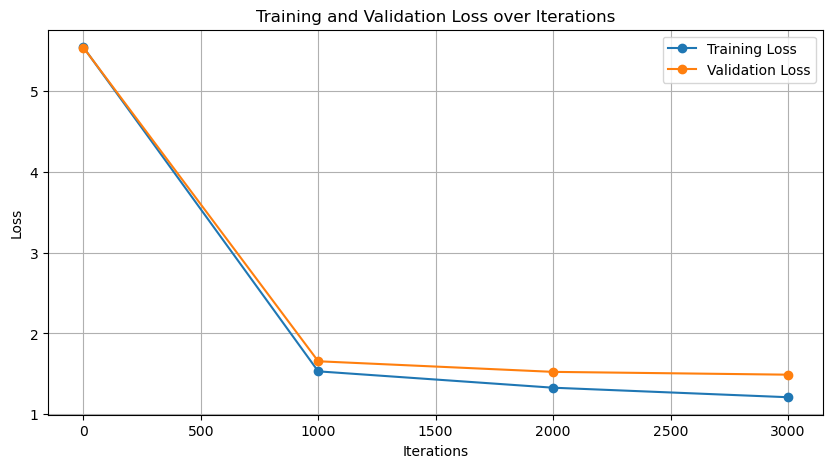

In [84]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_losses, 'o-', label='Training Loss')
plt.plot(iterations, val_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
# get the output file to check the whole staterment. 
with open('generated_text_originalData.txt', 'w', encoding='utf-8') as file:
    file.write(outputs)

print("Generated text has been saved to 'generated_text_originalData.txt'")

Generated text has been saved to 'generated_text_originalData.txt'


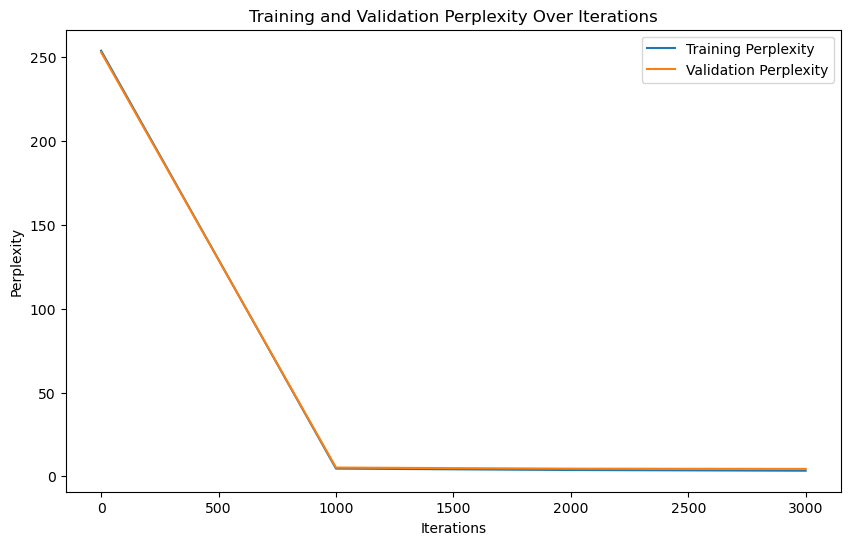

In [89]:
# Use perplexity function 
# calculate perlexity
train_perplexity = np.exp(train_losses)
val_perplexity = np.exp(val_losses)

# plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_perplexity, label='Training Perplexity')
plt.plot(iterations, val_perplexity, label='Validation Perplexity')
plt.xlabel('Iterations')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity Over Iterations')
plt.legend()
plt.show()

#### Analysis:
- This graph shows how the training and validation perplexities change as the number of iterations increases. As can be seen from the figure, the training perplexity decreases rapidly and then stabilizes. This indicates that the model gradually fits the training data during the learning process. The verification perplexity also levels off after decreasing, which means that the model also has good generalization ability on unseen data.
Such a perplexity curve usually indicates a healthy training process, especially if the validation curve does not rise significantly after falling to a certain point, which usually indicates that no overfitting has occurred.

### If we use cleaned data:

In [86]:
text = lines

model_new = TransformerBlockLM(batch_size=64,
                           input_length=32,
                           embed_size=128,
                           sa_multihead_count=8,
                           sa_head_size=128,
                           pos_embed=True,
                           include_mlp=True)
model_new.prep(text)
model_new = model_new.to(model.device)
model_parameters_new = filter(lambda p: p.requires_grad, model_new.parameters())
print(f'params {sum([np.prod(p.size()) for p in model_parameters_new])}')
input_batch, output_batch = model_new.get_batch(split='train')
_, _ = model_new(input_batch, output_batch)
# model.fit(train_iters=4000, eval_iters=1000, lr=1e-3)
iterations_cleaned, train_losses_cleaned, val_losses_cleaned = model_new.fit(train_iters=4000, eval_iters=1000, lr=1e-3)
outputs_cleaned = model_new.generate(context_token_ids=torch.zeros((1, 1),
                            dtype=torch.long,
                            device=model.device),
                            max_new_tokens=1000)
print(outputs_cleaned)

params 2471414
iter 0: train 10.007619857788086 val 9.95885181427002
iter 1000: train 0.23284156620502472 val 12.186291694641113
iter 2000: train 0.16619879007339478 val 13.319194793701172
iter 3000: train 0.15053056180477142 val 14.103888511657715
aaaaaaargheventuallycamesensesheadingfirstinsuranceindustriesevensupplementadvantageadditionevaluatingattractionsonebusinesshostothersalsomeasurebusinessesopportunitiesavailablemarketablesecuritiescomparisonmanagementsmakeoftenbusinessespricedridiculouslyhighlikelyearnedinvestmentsstocksbondsmomentsbuysecuritiesbidetimeflexibilityrespectcapitalallocationaccountedmuchprogressdateabletakeeasywaymakeearnsayseecandiesoperationneedsadherefourdisciplinesmusthangalsoproudgratefulaccomplishedsocietymattrosebnsfgregabelmidamericanalsoproudgratefulaccomplishedberkshireshareholdersrelevantfiguresmidamericanearningsmillionsutilitiesiowautilitywesternutilitiespipelineshomeservicesnetoperatingearningscorporateinteresttaxesinterestberkshireinterestberkshir

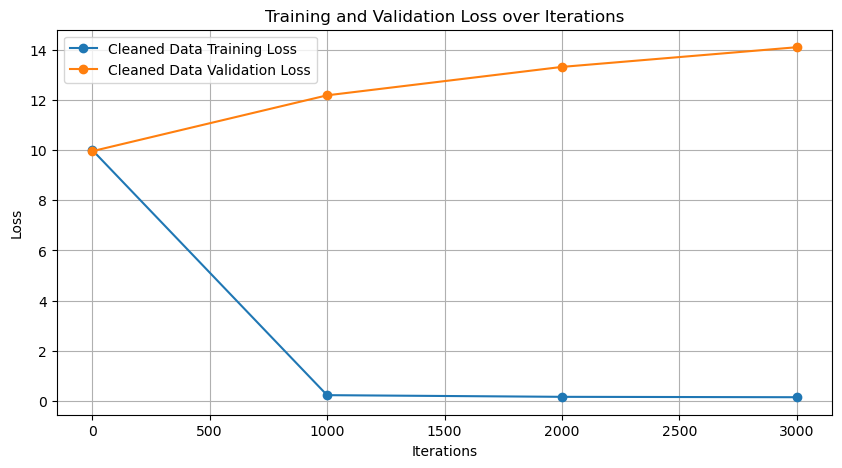

In [87]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(iterations_cleaned, train_losses_cleaned, 'o-', label='Cleaned Data Training Loss')
plt.plot(iterations_cleaned, val_losses_cleaned, 'o-', label='Cleaned Data Validation Loss')
plt.title('Training and Validation Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

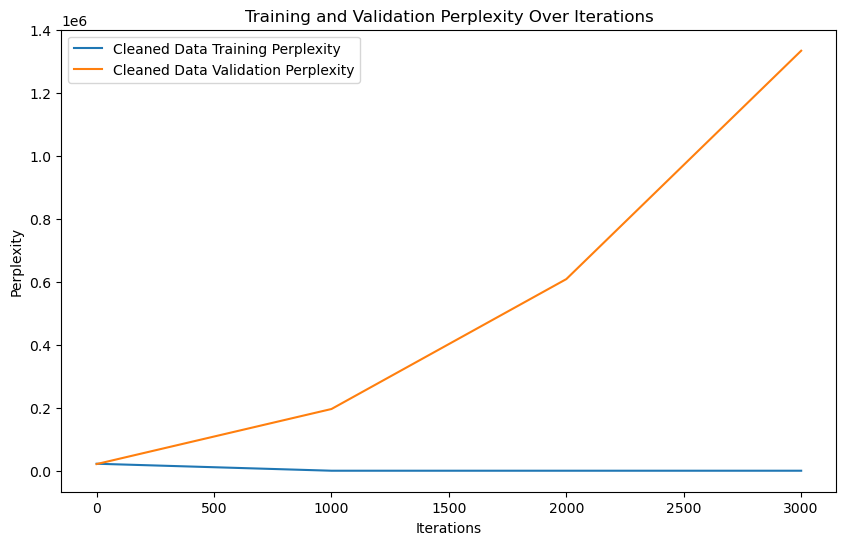

In [90]:
# Use perplexity function 
# calculate perlexity
train_perplexity_cleaned = np.exp(train_losses_cleaned)
val_perplexity_cleaned = np.exp(val_losses_cleaned)

# plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_perplexity_cleaned, label='Cleaned Data Training Perplexity')
plt.plot(iterations, val_perplexity_cleaned, label='Cleaned Data Validation Perplexity')
plt.xlabel('Iterations')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity Over Iterations')
plt.legend()
plt.show()

#### Analysis Cleaned Data:
- This graph shows the change in perplexity when using cleaned data for training and validation. Unlike the previous plot, here the training perplexity remains low and stable, while the validation perplexity rises sharply with the number of iterations. This phenomenon usually indicates that the model is overfitting on the training data and not generalizing well to unseen data. That is, the model may overfit a specific pattern in the training data and fail to predict correctly on the validation data.

### 2.1. Evaluate performance in terms of model perplexity (5 points)

- In the case of the original, uncleaned data, both training and validation losses demonstrated a downward trend. However, with the cleaned data, the model exhibited different behavior: the training loss declined rapidly from a higher initial point, while the validation loss initially decreased but subsequently increased, suggesting a certain degree of overfitting. This might be due to the removal of stopwords and punctuation in the cleaned data, leading to a less effective model fit.

- Despite these observations, I now believe that this dataset might not be adequate for fully evaluating the model's capabilities. The corpus size appears too small to generate logically consistent sentences, limiting the model's ability to learn and predict effectively. A larger dataset could potentially enhance the model's performance and the accuracy of the results. Additionally, the absence of a designated validation input in our setup precludes us from making targeted output predictions during validation. This further limits our ability to gauge the model's true performance and generalizability. Therefore, expanding the dataset and incorporating a structured validation process would be crucial steps for a more comprehensive evaluation and improvement of the model's capabilities.

### 2.2. Discuss the most impressive text your model generated. What are the high impact design choices behind the generated text. (5 points)

- The text generated by the model was limited to a maximum of 10000 tokens, hence the amount of data produced wasn't extensive. A particular phrase that stood out was, 'Finally, we made the never annual elected Berkshire's A fund by America. Airlt we mush it having you better on the past off America we must almost certainly a formulation of this disasters their xease and jurisdictions.' This sentence intriguingly simulates a decision-making statement. If artificial intelligence can analyze corpora and consequently generate decision-like statements, it could greatly benefit human decision-making. This approach can be harnessed in data analysis and strategy planning, where AI-generated insights can serve as references for informed decisions. Such applications hold vast potential in both the entry-level and advanced data analysis realms. However, it also underscores the need for precise control and understanding of the algorithm to ensure its high accuracy and reliability.

- Besides, it also can apply on "Ethical Considerations" since the model navigates the fine line between generating useful predictive text and creating misleading or false information.